### Download the dataset
<b>Dataset location: </b>https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset <br />
Number of riders using a bikeshare service on a given day. We will predict the number of riders given information about the type of day and weather

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName('Effects of Dimensionality Reduction when making predictions') \
    .getOrCreate()

rawData = spark.read\
            .format('csv')\
            .option('header', 'true')\
            .load('../datasets/day.csv')

In [4]:
rawData.toPandas().head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.2,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.22927,0.436957,0.1869,82,1518,1600


#### Select required columns from data
* The <i>instant</i> and <i>dteday</i> columns are dropped as they are unique, thus not useful for predictions
* The <i>casual</i> and <i>registered</i> fields will sum up to the cnt field which we wish to predict, so we remove those

In [4]:
from pyspark.sql.functions import col

dataset = rawData.select(col('season').cast('float'),
                         col('yr').cast('float'),
                         col('mnth').cast('float'),
                         col('holiday').cast('float'),
                         col('weekday').cast('float'),
                         col('workingday').cast('float'),
                         col('weathersit').cast('float'),
                         col('temp').cast('float'),
                         col('atemp').cast('float'),
                         col('hum').cast('float'),
                         col('windspeed').cast('float'),
                         col('cnt').cast('float')
                        )

dataset.toPandas().head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1.0,0.0,1.0,0.0,6.0,0.0,2.0,0.344167,0.363625,0.805833,0.160446,985.0
1,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.363478,0.353739,0.696087,0.248539,801.0
2,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.196364,0.189405,0.437273,0.248309,1349.0
3,1.0,0.0,1.0,0.0,2.0,1.0,1.0,0.200000,0.212122,0.590435,0.160296,1562.0
4,1.0,0.0,1.0,0.0,3.0,1.0,1.0,0.226957,0.229270,0.436957,0.186900,1600.0


#### Check correlation between fields
* <i>temp</i> and <i>atemp</i> are almost perfectly correlated
* <i>month</i> and <i>season</i> are also strongly correlated

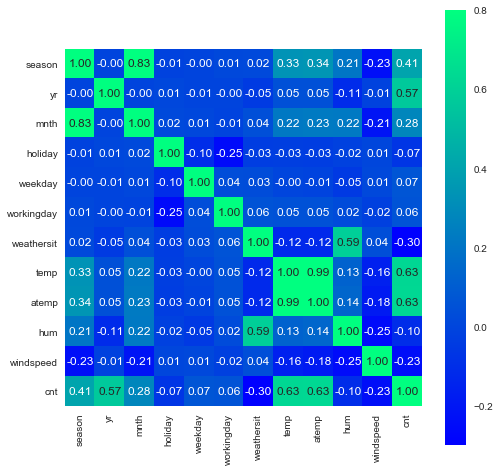

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

corrmat = dataset.toPandas().corr()
plt.figure(figsize=(8, 8))
sns.set(font_scale=1.0)
sns.heatmap(corrmat, vmax=.8, square=True, annot=True, fmt='.2f', cmap = "winter")
plt.show()

#### Select features
All fields except the <i>cnt</i> field make up our features

In [6]:
featureCols = dataset.columns.copy()
featureCols.remove('cnt')

featureCols

['season',
 'yr',
 'mnth',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed']

### The total number of features
We will reduce the dimensions later on

In [7]:
len(featureCols)

11

#### Construct the feature vector using an assembler

In [8]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=featureCols,
                            outputCol='features')

In [9]:
vectorDF = assembler.transform(dataset)
vectorDF.toPandas().head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,features
0,1.0,0.0,1.0,0.0,6.0,0.0,2.0,0.344167,0.363625,0.805833,0.160446,985.0,"[1.0, 0.0, 1.0, 0.0, 6.0, 0.0, 2.0, 0.34416699..."
1,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.363478,0.353739,0.696087,0.248539,801.0,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.36347800..."
2,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.196364,0.189405,0.437273,0.248309,1349.0,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.19636400..."
3,1.0,0.0,1.0,0.0,2.0,1.0,1.0,0.200000,0.212122,0.590435,0.160296,1562.0,"[1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.20000000..."
4,1.0,0.0,1.0,0.0,3.0,1.0,1.0,0.226957,0.229270,0.436957,0.186900,1600.0,"[1.0, 0.0, 1.0, 0.0, 3.0, 1.0, 1.0, 0.22695699..."


#### Prepare the training and test data sets

In [10]:
(trainingData, testData) = vectorDF.randomSplit([0.8, 0.2])

#### Create a simple Linear Regression model
We will not aim to get the best parameters here as our aim is to compare the model when used with regular features and then features with transformed and reduced dimensions

In [17]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(maxIter=100,
                      regParam=1.0,
                      elasticNetParam=0.8,
                      labelCol='cnt', 
                      featuresCol='features')

In [18]:
model = lr.fit(trainingData)

#### Calculate R-square and RMSE on training data

In [19]:
print('Training R^2 score = ', model.summary.r2)
print('Training RMSE = ', model.summary.rootMeanSquaredError)

Training R^2 score =  0.7900638415272152
Training RMSE =  893.0616722452457


#### Make predictions using test data

In [20]:
predictions = model.transform(testData)
predictions.toPandas().head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,features,prediction
0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.096522,0.098839,0.436522,0.246600,986.0,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.09652169...",849.654313
1,1.0,0.0,1.0,0.0,2.0,1.0,1.0,0.200000,0.212122,0.590435,0.160296,1562.0,"[1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.20000000...",1768.463575
2,1.0,0.0,1.0,0.0,2.0,1.0,2.0,0.223478,0.234526,0.616957,0.129796,1985.0,"[1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 2.0, 0.22347800...",1321.382417
3,1.0,0.0,1.0,0.0,3.0,1.0,3.0,0.217500,0.203600,0.862500,0.293850,506.0,"[1.0, 0.0, 1.0, 0.0, 3.0, 1.0, 3.0, 0.21750000...",14.549142
4,1.0,0.0,1.0,0.0,4.0,1.0,1.0,0.204348,0.233209,0.518261,0.089565,1606.0,"[1.0, 0.0, 1.0, 0.0, 4.0, 1.0, 1.0, 0.20434799...",2200.818081


#### R-square score on test data

In [21]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(
    labelCol='cnt', 
    predictionCol='prediction', 
    metricName='r2')

rsquare = evaluator.evaluate(predictions)
print("Test R^2 score = %g" % rsquare)

Test R^2 score = 0.835634


#### RMSE on test data

In [22]:
evaluator = RegressionEvaluator(
    labelCol='cnt', 
    predictionCol='prediction', 
    metricName='rmse')

rmse = evaluator.evaluate(predictions)
print('Test RMSE = ', rmse)

Test RMSE =  763.936846661404


#### Convert predictions dataframe to Pandas dataframe
This will make it easier for us to create a series which we will use to plot the actual and predicted values of <i>cnt</i>

In [73]:
predictionsPandas = predictions.toPandas()

#### Compare actual and predicted values of cnt

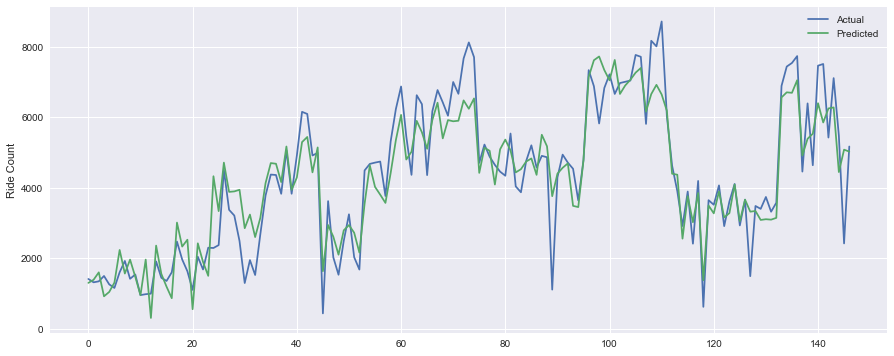

In [74]:
plt.figure(figsize=(15,6))

plt.plot(predictionsPandas['cnt'], label='Actual')
plt.plot(predictionsPandas['prediction'], label='Predicted')

plt.ylabel('Ride Count')
plt.legend()

plt.show()

### Principal Components Analysis
Performs an orthogonal transformation to convert a set of possibly correlated variables into a set of values of linearly uncorrelated variables called <b>principal components</b>
* the pcaTransformer will extract the principal components from the features
* the number of components is set by the value of <b>k</b>

In [23]:
from pyspark.ml.feature import PCA

pca = PCA(k=8, 
          inputCol='features', 
          outputCol='pcaFeatures'
         )

In [24]:
pcaTransformer = pca.fit(vectorDF)

#### View the principal components in the transformed space

In [25]:
pcaFeatureData = pcaTransformer.transform(vectorDF).\
                select('pcaFeatures')

pcaFeatureData.toPandas().head()

,pcaFeatures
0,"[-1.2994341051211487, -6.000295788252948, 0.38..."
1,"[-1.2560740466051405, -0.0018090609273897756, ..."
2,"[-1.2498374389125777, -1.0026992468169051, 0.5..."
3,"[-1.2589193782130974, -2.001860480004334, 0.57..."
4,"[-1.264951594573432, -3.0022673722336357, 0.58..."


#### The principal components are stored as a DenseVector

In [26]:
pcaFeatureData.toPandas()['pcaFeatures'][0]

DenseVector([-1.2994, -6.0003, 0.3846, -2.024, 0.458, -0.4848, 0.569, -0.0731])

#### Check the  Explained Variance 
This shows the eigen values of each principal component in decreasing order

In [27]:
pcaTransformer.explainedVariance

DenseVector([0.7093, 0.2227, 0.0201, 0.0171, 0.0137, 0.0119, 0.0028, 0.0014])

#### Scree plot
Visualise the explained variance. This can be used to eliminate dimensions with low eigen values

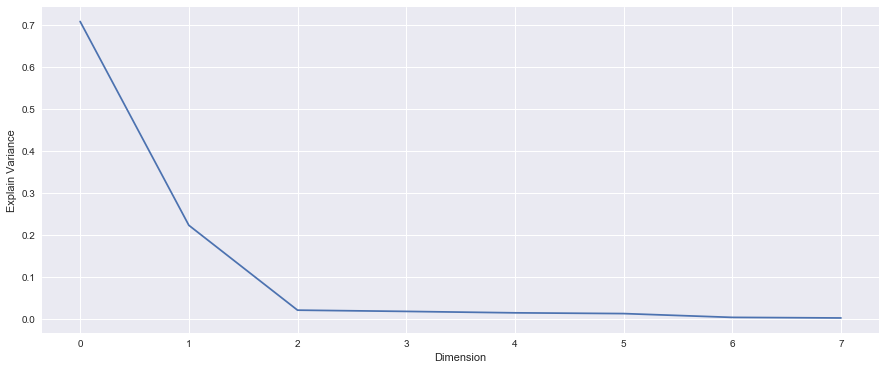

In [28]:
plt.figure(figsize=(15,6))

plt.plot(pcaTransformer.explainedVariance)
plt.xlabel('Dimension')
plt.ylabel('Explain Variance')
plt.show()

#### Prepare a dataset to use with the Linear Regression model
* We need to prepare a dataframe containing the principal components and the correct value of cnt
* We will retrieve the <i>pcaFeatures</i> column from pcaFeatureData and the <i>cnt</i> column from vectorDF
* In order to join these two dataframes, we need to create a column on which to join - for that we add a <i>row_index</i> field to each dataframe which we will use to perform the join

In [29]:
from pyspark.sql.functions import monotonically_increasing_id

pcaFeatureData = pcaFeatureData.withColumn('row_index', monotonically_increasing_id())
vectorDF = vectorDF.withColumn('row_index', monotonically_increasing_id())

#### Join the tables using the row_index field
We only extract the <i>cnt</i> and <i>pcaFeatures</i> fields which we require from the joined table

In [30]:
transformedData = pcaFeatureData.join(vectorDF, on=['row_index']).\
                sort('row_index').\
                select('cnt', 'pcaFeatures') 
        
transformedData.toPandas().head()

,cnt,pcaFeatures
0,985.0,"[-1.2994341051211487, -6.000295788252948, 0.38..."
1,801.0,"[-1.2560740466051405, -0.0018090609273897756, ..."
2,1349.0,"[-1.2498374389125777, -1.0026992468169051, 0.5..."
3,1562.0,"[-1.2589193782130974, -2.001860480004334, 0.57..."
4,1600.0,"[-1.264951594573432, -3.0022673722336357, 0.58..."


#### Prepare the training and test datasets from our new transformed dataset

In [31]:
(pcaTrainingData, pcaTestData) = transformedData.randomSplit([0.8,0.2])

#### Prepare the LinearRegression model
This has the exact same parameters as our previous model for a meaningful comparison

In [32]:
pcalr = LinearRegression(maxIter=100,
                      regParam=1.0,
                      elasticNetParam=0.8,
                      labelCol='cnt', 
                      featuresCol='pcaFeatures')

In [33]:
pcaModel = pcalr.fit(pcaTrainingData)

#### Calculate RMSE and R-square values on training data

In [34]:
print('Training R^2 score = ', pcaModel.summary.r2)
print('Training RMSE = ', pcaModel.summary.rootMeanSquaredError)

Training R^2 score =  0.7910122052343203
Training RMSE =  892.2460621869441


#### Perform predictions using the principal components

In [35]:
pcaPredictions = pcaModel.transform(pcaTestData)
pcaPredictions.toPandas().head()

,cnt,pcaFeatures,prediction
0,959.0,"[-1.2921840793046335, -6.001649593954054, 0.35...",713.623696
1,1606.0,"[-1.2729147965108116, -4.001723870685428, 0.59...",1899.246436
2,1162.0,"[-1.264461487277343, -3.0018075293624253, 0.56...",1534.173283
3,1000.0,"[-1.2585149270389007, -0.9938198326237606, 0.3...",-125.166474
4,1098.0,"[-1.2881136707453351, -5.992077073188351, 0.55...",1857.436251


#### Calculate R-square on test

In [36]:
evaluator = RegressionEvaluator(
    labelCol='cnt', 
    predictionCol='prediction', 
    metricName='r2')

rsquare = evaluator.evaluate(pcaPredictions)
print("Test R^2 score = %g" % rsquare)

Test R^2 score = 0.782874


#### RMSE on test

In [37]:
evaluator = RegressionEvaluator(
    labelCol='cnt', 
    predictionCol='prediction', 
    metricName='rmse')

rmse = evaluator.evaluate(pcaPredictions)
print('Test RMSE = ', rmse)

Test RMSE =  871.2910357929818


#### Convert predictions dataframe to a pandas dataframe
This will allow us to plot a graph of the predicted values against the actual values

In [38]:
pcaPredictionsPandas = pcaPredictions.toPandas()

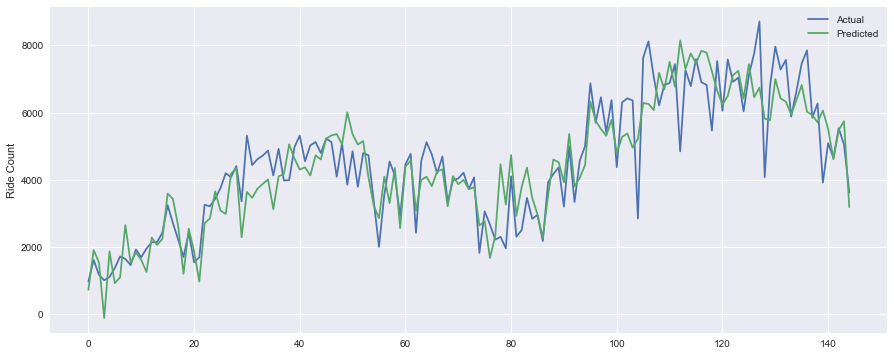

In [39]:
plt.figure(figsize=(15,6))

plt.plot(pcaPredictionsPandas['cnt'], label='Actual')
plt.plot(pcaPredictionsPandas['prediction'], label='Predicted')

plt.ylabel('Ride Count')
plt.legend()

plt.show()